In [0]:
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
from scipy import signal
import scipy.ndimage
import random
import cv2
from matplotlib import image as pltimage
#wav2spec2wav+mel compression


In [0]:
#https://timsainburg.com/python-mel-compression-inversion.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float32')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float32')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec

# From https://github.com/jameslyons/python_speech_features

def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)
    
def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"
    
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000, samplerate=44100):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(nfilt=n_freq_components, 
                                           nfft=fft_size, samplerate=samplerate, 
                                           lowfreq=start_freq, highfreq=end_freq)
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

In [0]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size//16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
sr = 44100 #44100 Hz,puedo usar highcut
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 
# Generate the mel filters
mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)

In [8]:
# Grab your wav and filter it
mywav = 'wav/chunk0.wav'
rate, data = wavfile.read(mywav)
print(rate)
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    print("SSSSSSSSS")
    data = data[0:rate*10] 
print('Length in time (s): ', np.shape(data)[0]/float(rate))
# Play the audio
IPython.display.Audio(data=data, rate=rate)

44100
Length in time (s):  2.0


(688, 1024)


Text(0.5, 1.05, 'Original Spectrogram')

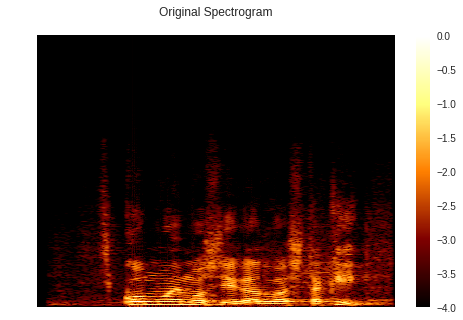

In [9]:
wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
cax.write_png("spectogram.png")
print(wav_spectrogram.shape)
fig.colorbar(cax)
plt.axis("off")
plt.title('Original Spectrogram')

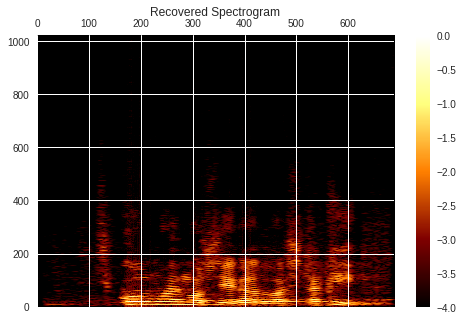

In [10]:
# Invert from the spectrogram back to a waveform
recovered_audio_orig = invert_pretty_spectrogram(wav_spectrogram, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

# Make a spectrogram of the inverted audio (for visualization)
inverted_spectrogram = pretty_spectrogram(recovered_audio_orig.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(np.transpose(inverted_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Recovered Spectrogram')
IPython.display.Audio(data=recovered_audio_orig, rate=rate) # play the audio

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Wav Spec Original: (688, 1024)_0.0_-4.0
Mel Spec Original: (64, 67)_-0.17668259_-4.0032983
mel Spectrogram Size: (64, 67)
Original Spectrogram Size: (1024, 688)
Original Waveform Size: (88200,)
Length (s): 2.0
Original Sampling Rate (ms) : 2.2675736961451248e-05
New Sampling Rate (ms): 33.5
[[-4. -4. -4. ... -4. -4. -4.]
 [-4. -4. -4. ... -4. -4. -4.]
 [-4. -4. -4. ... -4. -4. -4.]
 ...
 [-4. -4. -4. ... -4. -4. -4.]
 [-4. -4. -4. ... -4. -4. -4.]
 [-4. -4. -4. ... -4. -4. -4.]]
-4.0849442
-0.17430425


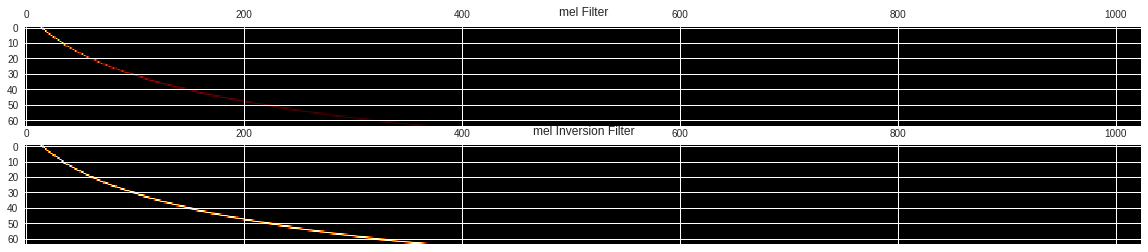

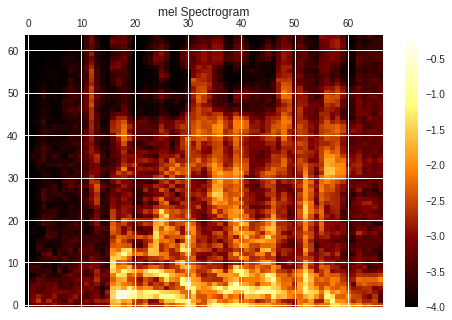

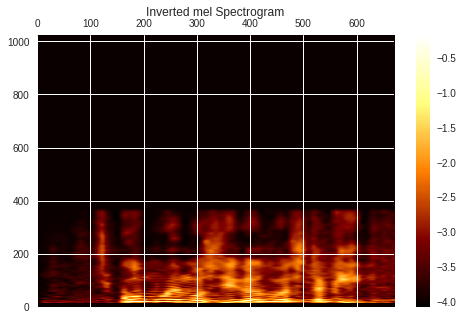

In [12]:
#MEL COMPRESSION


# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
#pltimage.imsave("grey.png", mel_spec)

# plot the compressed spec
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(mel_spec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
cax.write_png("mel_spec.png")
fig.colorbar(cax)
plt.title('mel Spectrogram')
print("Wav Spec Original: "+str(wav_spectrogram.shape)+"_"+str(wav_spectrogram.max())+"_"+str(wav_spectrogram.min()))
print("Mel Spec Original: "+str(mel_spec.shape)+"_"+str(mel_spec.max())+"_"+str(mel_spec.min()))

#spectgram from file
img_path = "specs_mel/m_spec_chunk0.wav.png"
#img_path = "gen/generated_999_5.png"
img =cv2.imread(img_path,1)
img_tensor = np.array(img)
img_tensor = img_tensor[:,:,0]#borramos rgb
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(img_tensor*255, cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Read img with cv2 Spectrogram')
print("FILE Mel Spec Original: "+str(img_tensor.shape)+"_"+str(img_tensor.max())+"_"+str(img_tensor.min()))
img_tensor= ((img_tensor/255)-1)*4
print("FILE Mel Spec Original: "+str(img_tensor.shape)+"_"+str(img_tensor.max())+"_"+str(img_tensor.min()))

# Output some stats of our file
print (''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))]))
print (''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))]))
print (''.join(['Original Waveform Size: ',str(np.shape(data))]))
print (''.join(['Length (s): ', str(len(data)/float(rate))]))
print (''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))]))
print (''.join(['New Sampling Rate (ms): ', str(float(np.shape(mel_spec)[1]) / (len(data)/float(rate)))]))



mel_inverted_spectrogram = mel_to_spectrogram(img_tensor, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)

print(mel_inverted_spectrogram)
print(mel_inverted_spectrogram.min())
print(mel_inverted_spectrogram.max())
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(mel_inverted_spectrogram, cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')


inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=inverted_mel_audio, rate=rate)

### **Load Data - Generate Spectograms**

In [0]:
!rm -rf wav
!mkdir wav
!pip install pydub
from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file("rajoy2.wav" , "wav") 
chunk_length_ms = 2000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = "wav/chunk{0}.wav".format(i)
    print ("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

In [8]:
!rm -rf specs
!rm -rf specs_mel
!mkdir specs
!mkdir specs_mel
from imutils import paths
def load_data():
  wav_spectrogram = None
  print("[INFO] Generating Spectograms from chunks...")
  wavPaths = sorted(list(paths.list_files("wav")))
  random.seed(22)
  random.shuffle(wavPaths)
  #MEL SPECTOGRAMS
  #mel_filter, mel_inversion_filter = create_mel_filter(fft_size = fft_size,
  #                                                      n_freq_components = n_mel_freq_components,
  #                                                      start_freq = start_freq,
  #                                                      end_freq = end_freq)
  # loop over the input images
  for wav in wavPaths:
    rate, data = wavfile.read(wav)
    data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
      print("?")
      data = data[0:rate*10]
    #NORMAL SPECTOGRAM  
    wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
    
    pltsave.imsave("specs/spec_"+wav.split("/")[1]+".png",wav_spectrogram)
    #fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
    #cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    #cax.write_png("specs/spec_"+wav.split("/")[1]+".png")
    

    mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor = shorten_factor)
    pltsave.imsave("specs_mel/m_spec_"+wav.split("/")[1]+".png",mel_spec)
    #cax = ax.matshow(mel_spec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    #cax.write_png("specs_mel/m_spec_"+wav.split("/")[1]+".png")

load_data()

[INFO] Generating Spectograms from chunks...


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(64, 67)
<class 'numpy.ndarray'>
(64, 67)
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/numpy/fft/fftpack.py:288: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


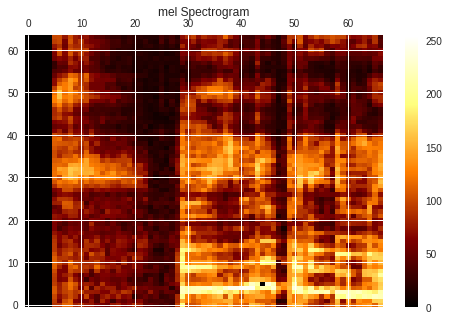

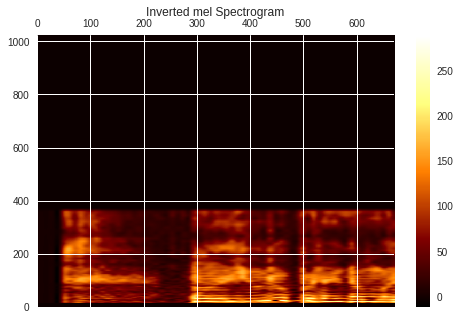

In [0]:
print(mel_spec.shape)
print(type(mel_spec))
img_path = "specs_mel/m_spec_chunk0.wav.png"
#img_path = "gen/generated_999_2.png"
img = cv2.imread(img_path, -1)


img_tensor = np.array(img)*255
#img_tensor = cv2.resize(img_tensor, (67, 64))


img_tensor = img_tensor[:,:,0]#borramos rgb
print(img_tensor.shape)
print(type(img_tensor))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(img_tensor, cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('mel Spectrogram')

mel_inverted_spectrogram = mel_to_spectrogram(img_tensor, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)


fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
cax = ax.matshow(mel_inverted_spectrogram, cmap=plt.cm.afmhot, origin='lower', aspect='auto',interpolation='nearest')
fig.colorbar(cax)
plt.title('Inverted mel Spectrogram')


inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

IPython.display.Audio(data=inverted_mel_audio, rate=rate)

# **GAN**



In [0]:
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Input,Reshape,LeakyReLU,Conv2DTranspose,ZeroPadding2D, Dropout
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras import regularizers
from keras.models import load_model
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltsave
import glob
import math
import random
import os
import time
import cv2


In [0]:
  PATH="specs_mel"#specs_mel=64x67 specs=1024x688(crop a 688x688) --dcgan 80x80
  IMG_SIZE=64#688
  EPOCHS=3000
  BATCH_SIZE=128
  LR=0.0005#learning rate for optimizer
  channels = 1
  data=[]

In [10]:
!mkdir gen
def load_data():
  data = []
  print("[INFO] Loading Data...")
  imagePaths = sorted(list(paths.list_images(PATH)))
  random.seed(42)
  random.shuffle(imagePaths)
  # loop over the input images
  for imagePath in imagePaths:
    #image = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)
    image = cv2.imread(imagePath,0)
    if IMG_SIZE>687:
      image=image[0:688,:,]#crop 688x1024-688x688  DESCOMENTAR SI 688
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    data.append(image)
  #normalize data for bestter optimization 0-1
  data = np.array(data, dtype="float") / 255.0
  print(len(data))
  return data
data = load_data()
print(data[0].shape)

[INFO] Loading Data...
602
(64, 64)


In [0]:
class DCGAN(object):
    def __init__(self, img_rows=IMG_SIZE, img_cols=IMG_SIZE, channel=channels):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channels
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 16#20 para 80x80, 172 para 688x688  16 para 64x64
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 80 x 80 x 3 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))#3 de channels
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [0]:
    def plot_images(save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'gen/gen.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "gen/samples_%d.png" % step
            images = generator.predict(noise)

        else:
            i = np.random.randint(0, x_train.shape[0], samples)
            images = x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            if channels==1:
              image=images[i, :, :, 0]
            else:
              image = images[i, :, :, :]
              image = np.reshape(image, [IMG_SIZE, IMG_SIZE,channels])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [0]:
    def train(train_steps=2000, batch_size=256, save_interval=100):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = x_train[np.random.randint(0,x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = generator.predict(noise)
            #print("Images train shape= ",images_train.shape)
            #print("Images noise shape= ",images_fake.shape)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    adversarial.save("models/adversarial"+str(i)+".h5")
                    discriminator.save("models/discriminator"+str(i)+".h5")
                    generator.save("models/generator"+str(i)+".h5")
                    plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))
                    gen_melspec2wav(samples=6,generator=generator,step=i)


In [0]:

x_train = data.reshape(-1, IMG_SIZE,IMG_SIZE, channels).astype(np.float32)

myDCGAN = DCGAN()
discriminator = myDCGAN.discriminator_model()
adversarial = myDCGAN.adversarial_model()
generator = myDCGAN.generator()

#discriminator=load_model("discriminator.h5")
#adversarial=load_model("adversarial.h5")
#generator=load_model("generator.h5")

In [0]:
!rm -rf gen
!mkdir gen
!mkdir models
train(train_steps=EPOCHS, batch_size=BATCH_SIZE, save_interval=500)
plot_images(fake=True)
plot_images(fake=False, save2file=True)

In [49]:
import librosa
import glob
import shutil
import scipy
from google.colab import drive
drive.mount('/content/drive/')

!mkdir audio
!rm -rf /content/drive/My Drive/GoogleColab/audio
#Save WAVS
sr=44100

imagePaths = [cv2.imread(file,1) for file in glob.glob('gen/generated*.png')]
#random.seed(42)
#random.shuffle(imagePaths)
print("[INFO] Transforming "+str(len(imagePaths))+" spectograms to wav...")  
# loop over the input images
i=0
for imagePath in imagePaths:
  img_tensor = np.array(imagePath)
  print(img_tensor.shape)
  img_tensor = img_tensor[:,:,0]#borramos rgb
  #MEL2SPEC
  mel_inverted_spectrogram = mel_to_spectrogram(img_tensor, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)
  mel_inverted_spectrogram = ((mel_inverted_spectrogram/255)-1)*4#normalize 0/-4
  #SPEC2WAV
  inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
  #print(inverted_mel_audio.shape)
  IPython.display.display(IPython.display.Audio(data=inverted_mel_audio, rate=sr))
  #librosa.output.write_wav("audio/"+str(i)+"_librosa.wav", inverted_mel_audio, sr)
  inverted_mel_audio = inverted_mel_audio*100
  scipy.io.wavfile.write("audio/"+str(i)+"_scipy.wav", sr, inverted_mel_audio)
  i=i+1


shutil.move("audio/", "/content/drive/My Drive/GoogleColab/turin")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mkdir: cannot create directory ‘audio’: File exists
[INFO] Transforming 1 spectograms to wav...
(64, 64, 3)


'/content/drive/My Drive/GoogleColab/turin/audio'

In [51]:
#shutil.copytree("models", "/content/drive/My Drive/GoogleColab/models")
from google.colab import drive
drive.mount('/content/drive/')
def gen_melspec2wav(samples,generator,step=0):
  if generator==None:
    generator = load_model("models/generator.h5")
  noise=np.random.uniform(-1.0, 1.0, size=[samples, 100])
  images = generator.predict(noise)
  for i in range(images.shape[0]):
    filename = "gen/generated_"+str(step)+"_"+str(i)+".png"
    imageA = np.reshape(images[i], [64, 64,channels])
    if channels==1:
      imageA = imageA[:,:,0]#delete rgb
    pltsave.imsave(filename, imageA)
    imageG = cv2.imread(filename,1)
    imageG = imageG[:,:,0]#delete rgb
    #imagePaths = [cv2.imread(file,1) for file in glob.glob('turin/generated*.png')]
    #MEL2SPEC
    mel_inverted_spectrogram = mel_to_spectrogram(imageG, mel_inversion_filter,
                                                spec_thresh=spec_thresh,
                                                shorten_factor=shorten_factor)
    mel_inverted_spectrogram = ((mel_inverted_spectrogram/255)-1)*4#normalize 0/-4
    #SPEC2WAV
    inverted_mel_audio = invert_pretty_spectrogram(np.transpose(mel_inverted_spectrogram), fft_size = fft_size,
                                              step_size = step_size, log = True, n_iter = 10)
    inverted_mel_audio = inverted_mel_audio*100
    scipy.io.wavfile.write("/content/drive/My Drive/GoogleColab/turin/gen_E"+str(step)+"_"+str(i)+".wav", sr, inverted_mel_audio)

  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
